## Introduction
Housing is an important part of modern society because it is not only an independent object, but also tied to the social resources of the city, such as education, health care, entertainment and life. People's instinctive need for these ancillary attributes has led to all social classes taking houses as an important personal asset and investment goal, which has given rise to a series of social problems such as the uneven distribution of urban resources and soaring house prices.

Before studying how to predict housing prices, it is important to understand that housing prices are determined by a variety of factors, including demographic, economic, and social factors at the macro level, and characteristics of the house itself at the micro level, such as its configuration, year of construction, and geographic location, etc. This study intends to start from these two aspects, using factors such as median income, population, average number of properties owned, number of rooms in houses, and geographical location in the U.S. state of California by census area, to attempt to find a suitable model for predicting house prices.



## Literature review
Currently, there are two main approaches to quantitative forecasting of housing prices: one views changes in housing prices as a time series for prediction, while the other analyzes factors influencing housing prices and uses these factors to build models for prediction.

For time series prediction, Rangan Gupta predicted the growth rate of house prices in four regions of the United States through dynamic factor analysis and Bayesian shrinkage estimation of a time series model(Gupta, 2013), and Serrano provided a methodology for predicting time series price data based on an RNN model, which was validated from the domains of the UK's real estate, equities, and fintech markets(Serrano, 2022).

In terms of prediction for influencing factors, Naalla Vineeth and others built house price prediction models by using simple linear regression, multiple linear regression and neural networks in machine learning algorithms(Vineeth et al., 2018), and Featherma predicted house prices for 20,000 second-hand houses in Beijing from multiple variable dimensions by constructing a random forest model(Featherman et al., 2003). 

It can be said that quantitative research on housing prices, regardless of the angle taken, can provide guidance for policymakers as well as offer advice and direction for real estate developers and homebuyers.



## Research question
Based on the understanding of current research perspectives and methods, the problems we are studying are:

(1) Among multiple linear regression, random forest, and XGBoost, which method performs best in predicting housing prices in California? 

(2) Among the elements involved in the dataset, which is the most significant factor affecting housing prices in California?



## Presentation of Data

This study utilizes California census data released by the U.S. Census Bureau, collected at the block level, including key indicators such as the number of people, median income, and median housing prices for each block. Based on this data, the study adopts the block as the unit of analysis to explore factors that affect housing prices and to identify appropriate methods for predicting housing prices.

Import the necessary Python packages.

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import randint, uniform
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from rfpimp import importances, plot_importances
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm


First, we'll read the data we need and understand the basic information about it, including the names and data types of the columns:

`Longitude/latitude`: Contains the geographical location information for each block.

`housing_median_age`: The median age of all houses.

`total_rooms`: Total number of rooms in all houses.

`Total_bedrooms`: Total number of bedrooms in all houses.

`Population`: Number of residents in the census area.

`Households`: Number of families living in the block.

`Median_income`: Median income of residents.

`Median_house_value`: Median value of the houses.

`Ocean_proximity`: The relative distance of the statistical area to the ocean.



In [3]:
# load data
housing = pd.read_csv("https://raw.githubusercontent.com/OnTheMon/CASA0006-Data-Science-for-Spatial-Systems/main/housing.csv")
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Now, to get a preliminary understanding of the raw data, using histograms can help us grasp the distribution status of the data. 

This approach allows us to visually inspect the spread, central tendency, and skewness of each variable in the dataset, which can be critical for identifying trends, outliers, and the need for data normalization or transformation before further analysis.

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

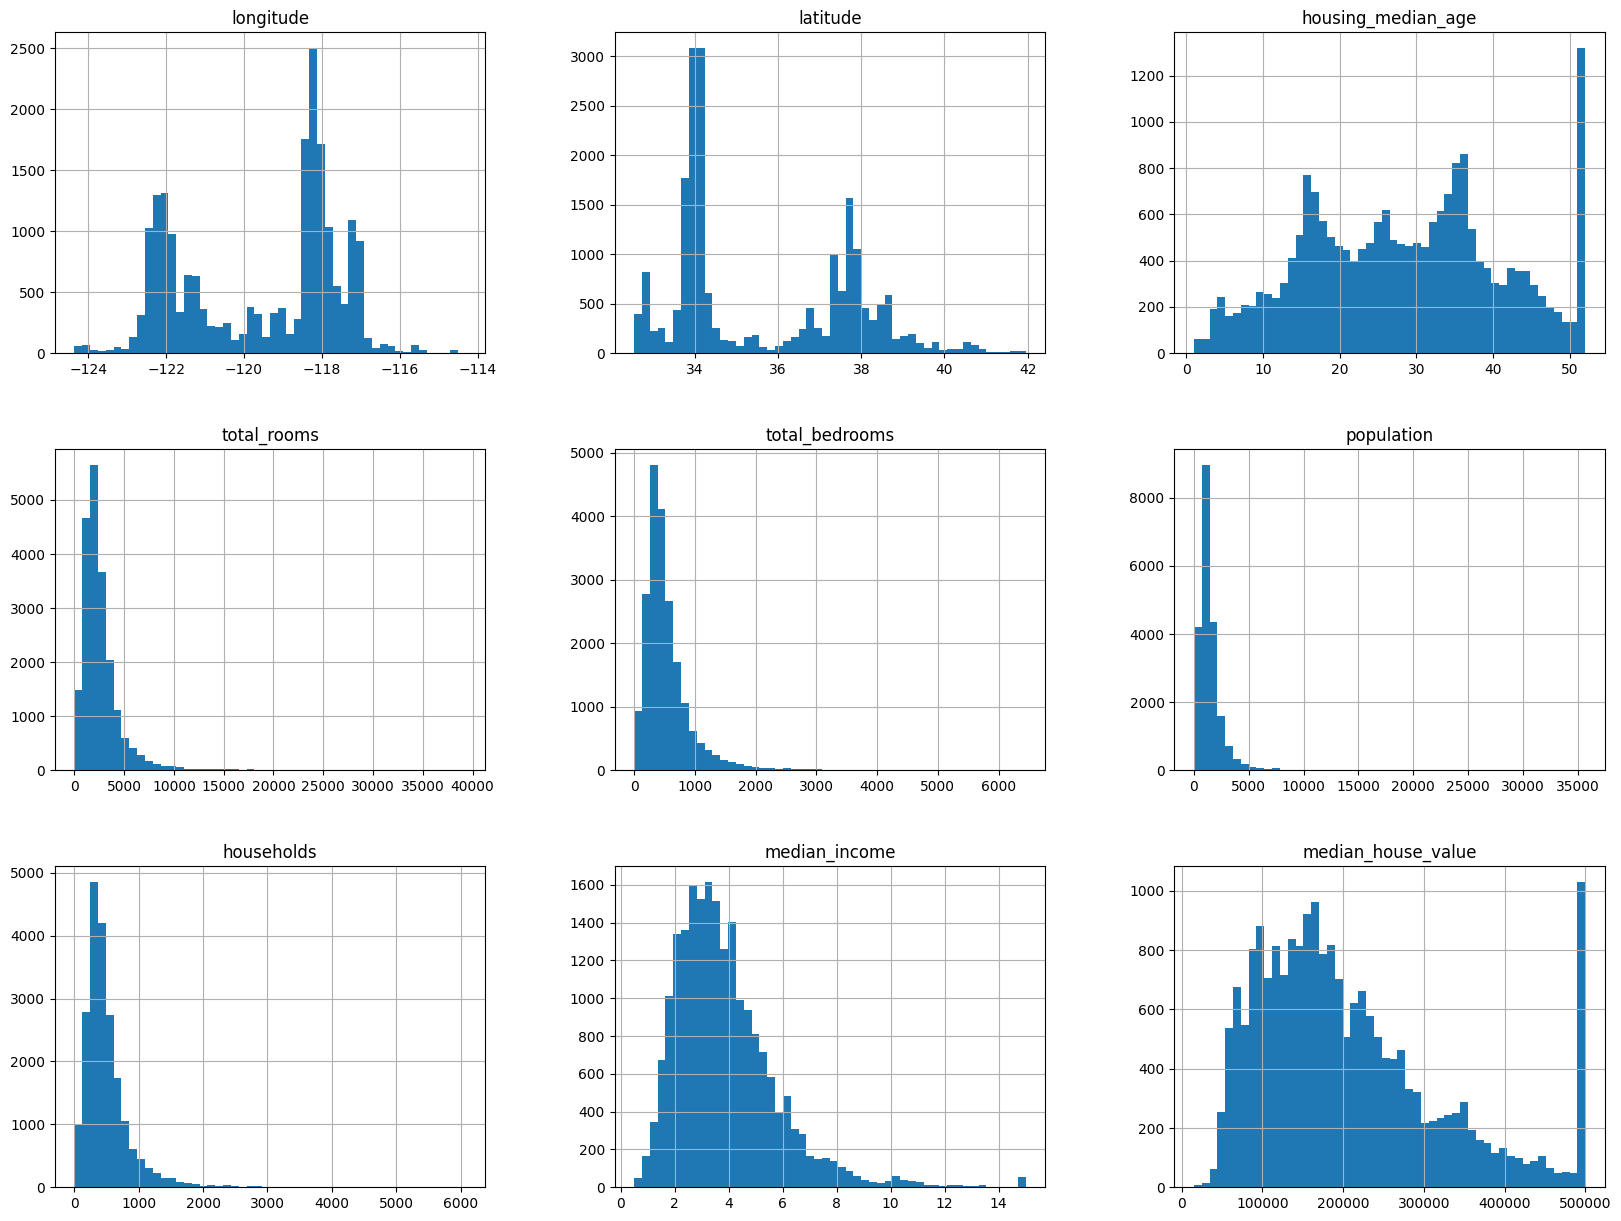

In [4]:
# Now display the histogram
housing.hist(bins=50, figsize=(20, 15))

As the histogram results show, we can clearly see anomalies in the number of houses where `housing_median_age` is greater than 51 and `median_house_value` exceeds 500,000. Such data anomalies might affect subsequent prediction results. Therefore, before proceeding with further analysis, we need to remove these outliers. Additionally, we should also filter out any rows with missing values and delete them. Histograms of the data after these deletions will indicate that the processed data is now suitable for further analysis. This step ensures the robustness and reliability of our predictive models by mitigating the impact of extreme values and missing information.

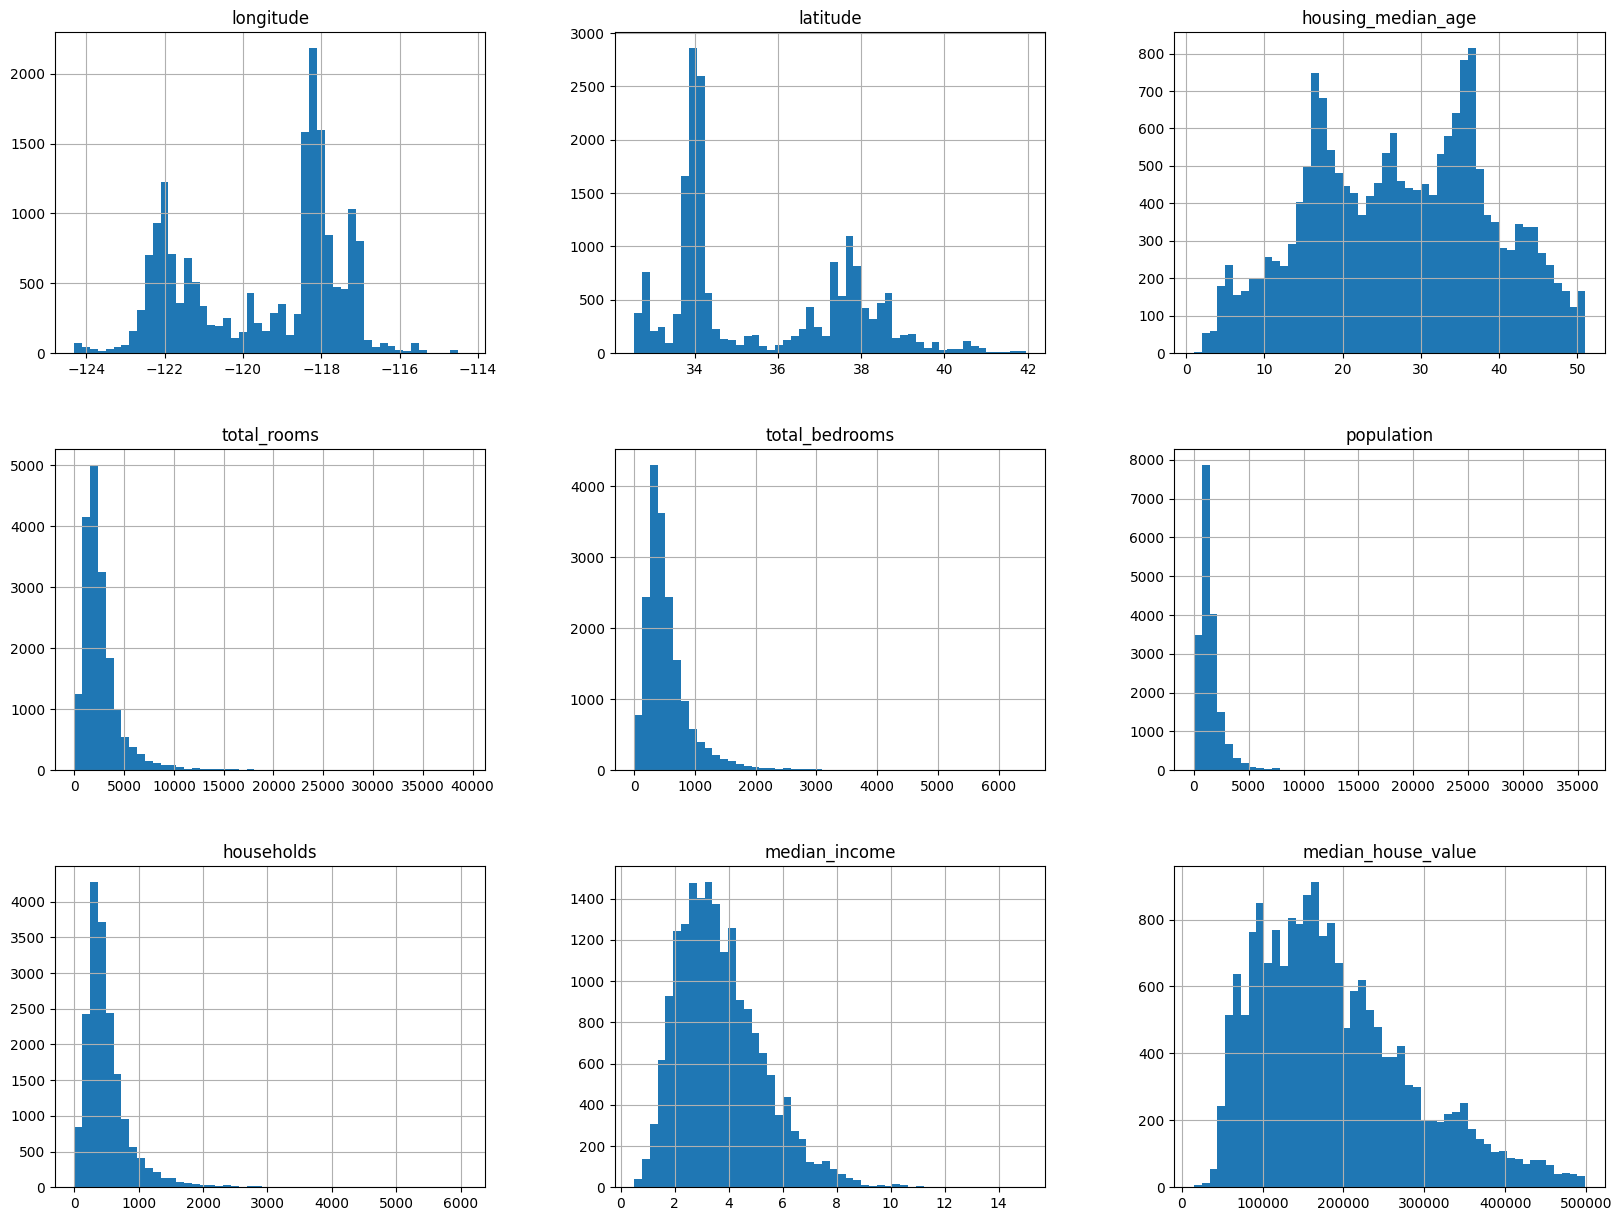

In [5]:
# Filter DataFrame to remove outliers
housing_filtered = housing[(housing['median_house_value'] < 500000) & (housing['housing_median_age'] < 52)]

# Delete rows containing missing values
housing_filtered = housing_filtered.dropna()

# Display the histogram now
housing_filtered.hist(bins=50, figsize=(20, 15))
plt.show()


After initial data processing, visualizing the data on a map reveals that California real estate is spatially concentrated around major coastal cities such as Los Angeles and San Francisco. Regarding the distribution of property prices, properties closer to the coast tend to have higher prices, and high-value properties are also concentrated in urban areas. This geographic visualization helps identify trends and insights that might not be as obvious from tabular data alone, highlighting the importance of location in real estate valuation.

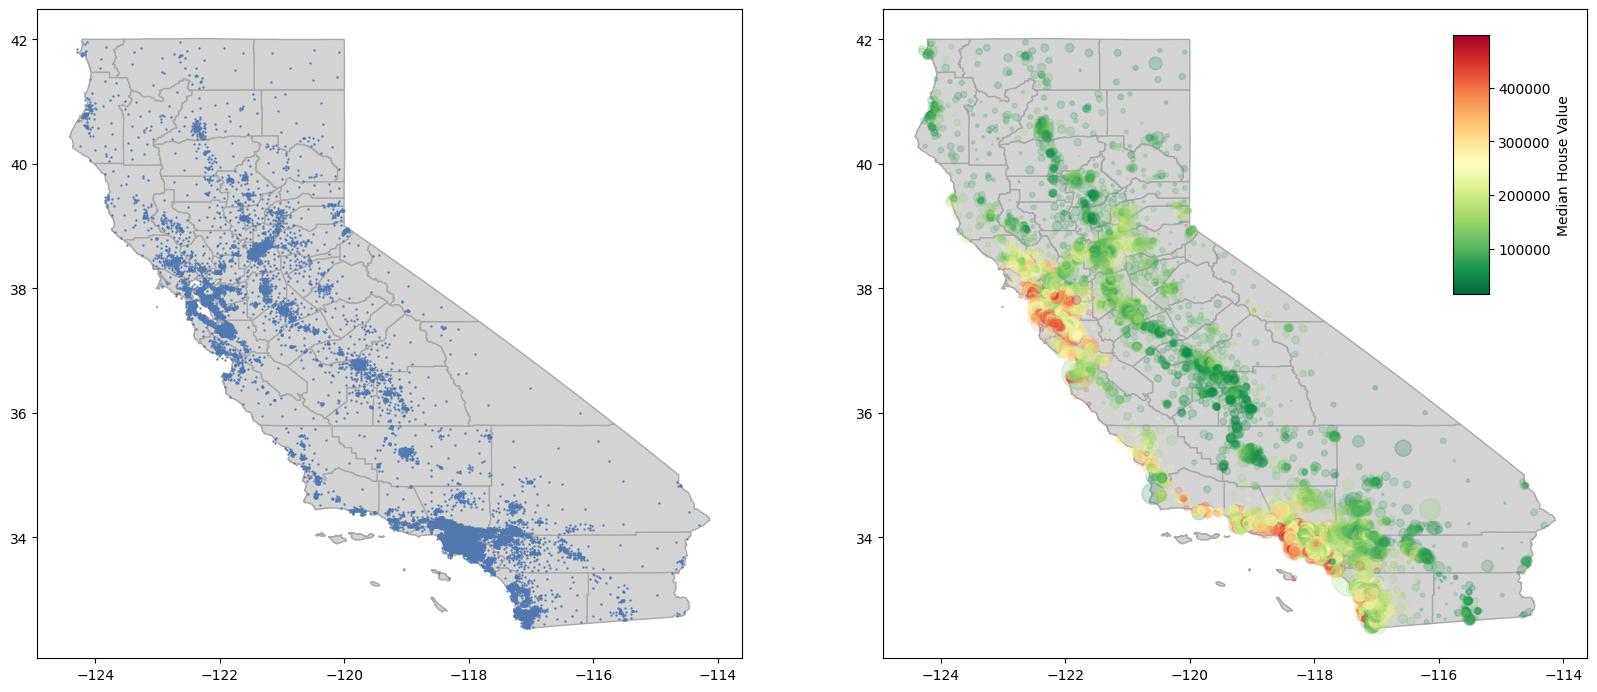

In [6]:
# Load .shp file as a map base layer
california_map = gpd.read_file(r"https://raw.githubusercontent.com/OnTheMon/CASA0006-Data-Science-for-Spatial-Systems/main/California.shp")

gdf1 = gpd.GeoDataFrame(housing_filtered, geometry=gpd.points_from_xy(housing_filtered.longitude, housing_filtered.latitude))
gdf2 = gpd.GeoDataFrame(housing_filtered, geometry=gpd.points_from_xy(housing_filtered.longitude, housing_filtered.latitude))

# Set up the color mapping
colormap = cm.ScalarMappable(Normalize(vmin=min(housing_filtered.median_house_value), vmax=max(housing_filtered.median_house_value)), cm.RdYlGn_r)

# Create a large figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# First plot
california_map.plot(ax=ax1, color='lightgrey', edgecolor='darkgrey')
gdf1.plot(ax=ax1, marker='o', color='#5178AF', markersize=0.5,  alpha=0.9)


# Second plot
california_map.plot(ax=ax2, color='lightgrey', edgecolor='darkgrey')
gdf2.plot(ax=ax2, marker='o', color=colormap.to_rgba(housing_filtered.median_house_value),
          markersize=housing_filtered.population / 50, alpha=0.2)
# Insert legend
axins = inset_axes(ax2, width="5%", height="40%", loc='lower left',
                   bbox_to_anchor=(0.8, 0.55, 1, 1), bbox_transform=ax2.transAxes)
fig.colorbar(colormap, cax=axins, label='Median House Value')

plt.show()


Based on the spatial distribution insights, it is reasonable to hypothesize that housing prices are likely higher in areas with denser populations, more developed economies, and closer proximity to the coast. To further confirm our hypothesis, it's necessary to delve deeper into the existing data. However, before we begin analyzing correlations between variables, it's important to note that the "ocean_proximity" column is categorical, not numerical. To facilitate subsequent analysis, we need to convert this categorical variable into numerical format using one-hot encoding.

In [7]:
# Select list of numeric columns
numerical_cols = housing_filtered.select_dtypes(include=['number']).columns

# Select categorical variables and apply OneHotEncoder
categorical_cols = housing_filtered.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False)
housing_cat_encoded = encoder.fit_transform(housing_filtered[categorical_cols])
housing_cat_encoded_df = pd.DataFrame(housing_cat_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Merge the encoded categorical variables with the original numeric data
housing_filtered = pd.concat([housing_filtered[numerical_cols].reset_index(drop=True), housing_cat_encoded_df], axis=1).drop(['longitude', 'latitude'], axis=1)


The correlation matrix of the variables indicates that `median_income` has the highest correlation with housing prices, with a correlation coefficient of approximately 0.66. Among other variables,`total_bedrooms`, `total_rooms`, `population`,and `households` all show strong correlations with each other, indicating potential multicollinearity that could affect the construction of subsequent models. To address this, we propose creating three new features to replace the original ones, potentially reducing multicollinearity and refining the model’s predictive accuracy.

In [8]:

corr_matrix=housing_filtered.corr()
corr_matrix

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
housing_median_age,1.000000,-0.374169,-0.330920,-0.280235,-0.310552,-0.201956,0.014647,0.107779,-0.221510,0.000943,0.142072,0.036381
total_rooms,-0.374169,1.000000,0.935415,0.860279,0.922493,0.222716,0.152861,-0.015243,0.028187,-0.006906,-0.004885,-0.013200
total_bedrooms,-0.330920,0.935415,1.000000,0.880314,0.978815,0.021396,0.079879,0.013211,-0.011524,-0.004386,-0.008691,0.004109
population,-0.280235,0.860279,0.880314,1.000000,0.910656,0.040595,0.021622,0.070546,-0.035739,-0.007954,-0.039164,-0.021635
households,-0.310552,0.922493,0.978815,0.910656,1.000000,0.045970,0.099419,0.038823,-0.045152,-0.006874,0.000557,0.006159
median_income,-0.201956,0.222716,0.021396,0.040595,0.045970,1.000000,0.664367,0.184465,-0.225379,-0.008727,0.060780,-0.004764
median_house_value,0.014647,0.152861,0.079879,0.021622,0.099419,0.664367,1.000000,0.318499,-0.501157,0.019648,0.111424,0.145916
ocean_proximity_<1H OCEAN,0.107779,-0.015243,0.013211,0.070546,0.038823,0.184465,0.318499,1.000000,-0.650196,-0.009402,-0.273345,-0.340644
ocean_proximity_INLAND,-0.221510,0.028187,-0.011524,-0.035739,-0.045152,-0.225379,-0.501157,-0.650196,1.000000,-0.007533,-0.218994,-0.272912
ocean_proximity_ISLAND,0.000943,-0.006906,-0.004386,-0.007954,-0.006874,-0.008727,0.019648,-0.009402,-0.007533,1.000000,-0.003167,-0.003947


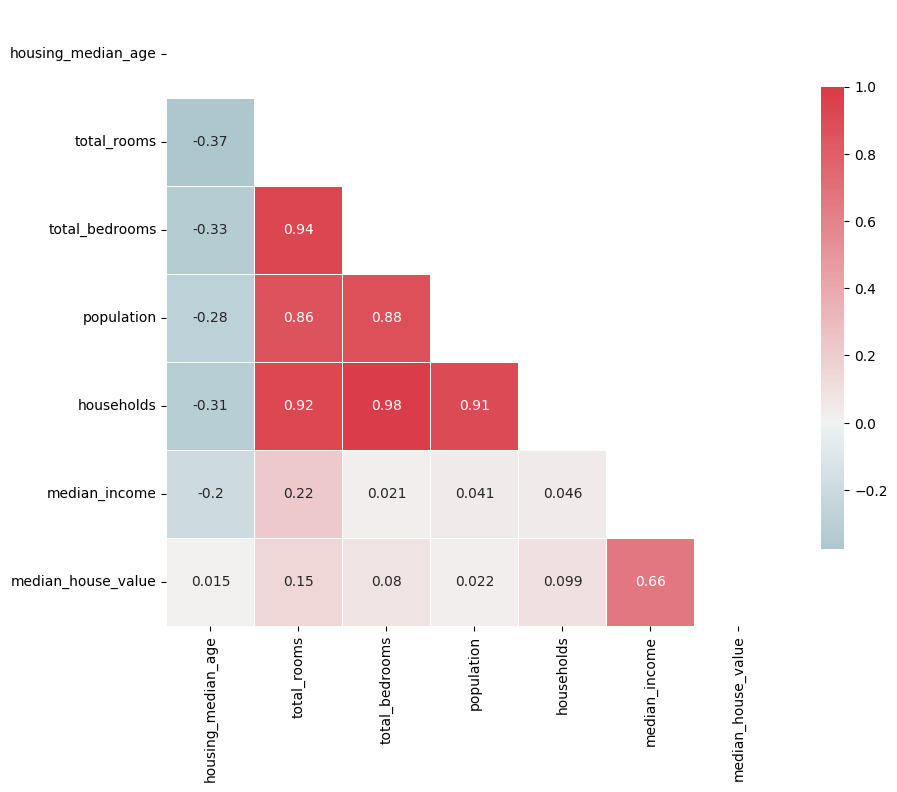

In [9]:
# Selecting specific columns for the correlation matrix
columns = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
data_selected = housing_filtered[columns]

# Calculating the correlation matrix
corr = data_selected.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75}, annot=True)

plt.show()

In [10]:
# Create new features and delete the original columns
housing_filtered["rooms_per_household"] = housing_filtered["total_rooms"] / housing_filtered["households"]
housing_filtered["bedrooms_per_room"] = housing_filtered["total_bedrooms"] / housing_filtered["total_rooms"]
housing_filtered["population_per_household"] = housing_filtered["population"] / housing_filtered["households"]
housing_prepared = housing_filtered.drop(['total_rooms', 'total_bedrooms', 'population', 'households'], axis=1)


The recalculated correlation matrix shows that the newly combined features are more suitable for further research.

In [11]:

corr_matrix=housing_prepared.corr()
corr_matrix

,housing_median_age,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,rooms_per_household,bedrooms_per_room,population_per_household
housing_median_age,1.000000,-0.201956,0.014647,0.107779,-0.221510,0.000943,0.142072,0.036381,-0.180774,0.146957,0.019792
median_income,-0.201956,1.000000,0.664367,0.184465,-0.225379,-0.008727,0.060780,-0.004764,0.315712,-0.633561,0.025670
median_house_value,0.014647,0.664367,1.000000,0.318499,-0.501157,0.019648,0.111424,0.145916,0.114573,-0.232835,-0.020127
ocean_proximity_<1H OCEAN,0.107779,0.184465,0.318499,1.000000,-0.650196,-0.009402,-0.273345,-0.340644,-0.124133,0.103541,-0.001867
ocean_proximity_INLAND,-0.221510,-0.225379,-0.501157,-0.650196,1.000000,-0.007533,-0.218994,-0.272912,0.180137,-0.141724,0.011479
ocean_proximity_ISLAND,0.000943,-0.008727,0.019648,-0.009402,-0.007533,1.000000,-0.003167,-0.003947,-0.003516,0.017103,-0.000736
ocean_proximity_NEAR BAY,0.142072,0.060780,0.111424,-0.273345,-0.218994,-0.003167,1.000000,-0.114733,-0.022351,-0.018854,-0.012226
ocean_proximity_NEAR OCEAN,0.036381,-0.004764,0.145916,-0.340644,-0.272912,-0.003947,-0.114733,1.000000,-0.052919,0.062949,-0.003368
rooms_per_household,-0.180774,0.315712,0.114573,-0.124133,0.180137,-0.003516,-0.022351,-0.052919,1.000000,-0.417847,-0.007089
bedrooms_per_room,0.146957,-0.633561,-0.232835,0.103541,-0.141724,0.017103,-0.018854,0.062949,-0.417847,1.000000,0.004232


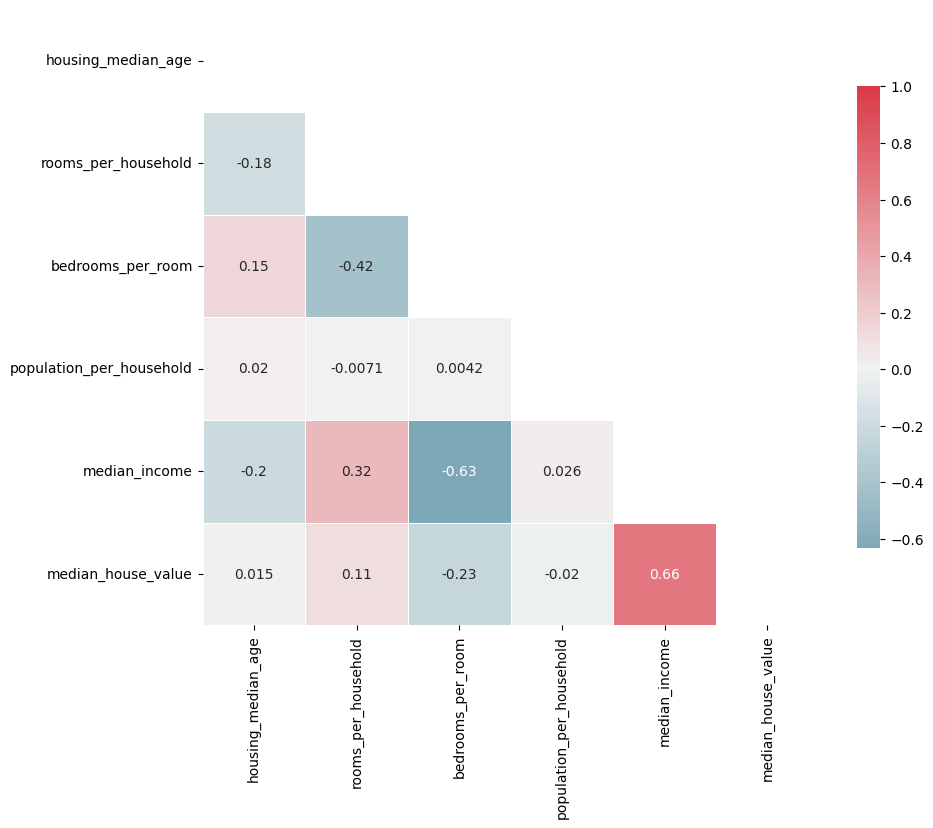

In [12]:
# Selecting specific columns for the correlation matrix
columns = ['housing_median_age', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household',  'median_income', 'median_house_value']
data_selected = housing_prepared[columns]

# Calculating the correlation matrix
corr = data_selected.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75}, annot=True)

plt.show()

A crucial step in using machine learning methods is the division of the data into training and testing sets. We use stratified sampling to split the original dataset, based on the previous finding that income is the primary factor influencing housing prices and is critical for predicting median house values. Therefore, we choose median_income as the basis for stratified sampling.

In [14]:
# Create income categories for stratified sampling
housing_prepared['income_cat'] = pd.cut(housing_prepared['median_income'],
                                        bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                        labels=[1, 2, 3, 4, 5])
housing_prepared = housing_prepared.reset_index(drop=True)
# Use StratifiedShuffleSplit for stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_prepared, housing_prepared['income_cat']):
    train_set = housing_prepared.loc[train_index]
    test_set = housing_prepared.loc[test_index]

# Remove the 'income_cat' column
train_set = train_set.drop('income_cat', axis=1)
test_set = test_set.drop('income_cat', axis=1)


To enhance the efficiency of processing, we also perform data normalization on both the training and testing sets. For this, we use the **MinMaxScaler** method, which scales each feature to a given range, usually 0 to 1, ensuring that our machine learning models handle all features uniformly and improving the convergence speed during training. This method is particularly effective in preserving the relationships among the original data points while transforming them into a scale suitable for model training.

In [15]:
# Select features to normalize (excluding the target variable)
features_to_normalize = train_set.columns.difference(['median_house_value'])

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Normalize the training set
train_set[features_to_normalize] = scaler.fit_transform(train_set[features_to_normalize])

# Normalize the test set
test_set[features_to_normalize] = scaler.transform(test_set[features_to_normalize])

X_train = train_set.drop('median_house_value', axis=1)  # Assume 'median_house_value' is the target column
y_train = train_set['median_house_value']

X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value']


## Methodology
In the selection of regression models, we sequentially use the following approaches:

(1) **Multiple Linear Regression**: This is a fundamental predictive technique in statistics that attempts to establish a linear relationship between multiple independent variables and one dependent variable. It allows for a quick understanding of the impact of various factors on the outcome and assesses the importance of each variable. However, its effectiveness can be limited when the data contains non-linear relationships.

(2) **Random Forest**: Random Forest is an ensemble learning method based on decision trees. It improves prediction accuracy and stability by constructing multiple decision trees and averaging or using a majority vote of their predictions. It performs particularly well with complex non-linear datasets.

(3) **XGBoost**: XGBoost (Extreme Gradient Boosting) is an implementation of gradient boosting decision trees. It builds trees sequentially, with each tree attempting to correct the prediction errors of the previous one. XGBoost offers numerous adjustable parameters, such as tree depth and learning rate, allowing the model to be flexibly adapted to different data characteristics.



For evaluation, we combine results from metrics such as `R²` and `RMSE` to assess the effectiveness of the three models. When optimizing the Random Forest and XGBoost models, we consider using a random search method for hyperparameter tuning. Random search is similar to grid search, but instead of trying all possible combinations, it selects a random value for each hyperparameter during each iteration and evaluates a certain number of random combinations. This is more efficient when dealing with larger hyperparameter search ranges.

In [16]:


# Ensure feature names do not contain disallowed characters
X_train_cleaned = X_train.rename(columns=lambda x: x.translate(str.maketrans('', '', '[],<>')))
X_test_cleaned = X_test.rename(columns=lambda x: x.translate(str.maketrans('', '', '[],<>')))

# Hyperparameter distribution for Random Forest
rf_param_dist = {
    'max_depth': (10, 50), 
    'min_samples_split': (2, 10)
}

# Hyperparameter distribution for XGBoost
xgb_param_dist = {
    'n_estimators': randint(3, 30),
    'max_depth': randint(10, 50)
}
# Linear Regression model
lr = LinearRegression()
# Create Random Forest and XGBoost models
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV
rf_search = RandomizedSearchCV(rf, rf_param_dist, n_iter=4, scoring='neg_mean_squared_error', cv=5, random_state=42, verbose=1)
xgb_search = RandomizedSearchCV(xgb, xgb_param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42, verbose=1)

# Fit models
print("Optimizing Linear Regression...")
lr.fit(X_train_cleaned, y_train)
print("Optimizing Random Forest...")
rf_search.fit(X_train_cleaned, y_train)
print("Best parameters for Random Forest:")
print(rf_search.best_params_)
print("Optimizing XGBoost...")
xgb_search.fit(X_train_cleaned, y_train)
print("Best parameters for XGBoost:")
print(xgb_search.best_params_)

# Best models
rf_best = rf_search.best_estimator_
xgb_best = xgb_search.best_estimator_


Optimizing Linear Regression...
Optimizing Random Forest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Random Forest:
{'min_samples_split': 10, 'max_depth': 10}
Optimizing XGBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for XGBoost:
{'max_depth': 17, 'n_estimators': 23}


In [17]:
# Calculate R² and RMSE
metrics = pd.DataFrame(index=['Linear Regression', 'Random Forest', 'XGBoost'], columns=['R²', 'RMSE'])

# Linear Regression model
lr_pred = lr.predict(X_test_cleaned)
metrics.loc['Linear Regression'] = [r2_score(y_test, lr_pred), np.sqrt(mean_squared_error(y_test, lr_pred))]

# Random Forest
rf_pred = rf_best.predict(X_test_cleaned)
metrics.loc['Random Forest'] = [r2_score(y_test, rf_pred), np.sqrt(mean_squared_error(y_test, rf_pred))]

# XGBoost
xgb_pred = xgb_best.predict(X_test_cleaned)
metrics.loc['XGBoost'] = [r2_score(y_test, xgb_pred), np.sqrt(mean_squared_error(y_test, xgb_pred))]

print(metrics)


                         R²          RMSE
Linear Regression  0.591196  60797.574177
Random Forest      0.678106  53949.257489
XGBoost            0.616166  58911.528324


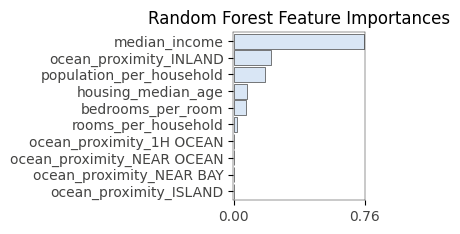

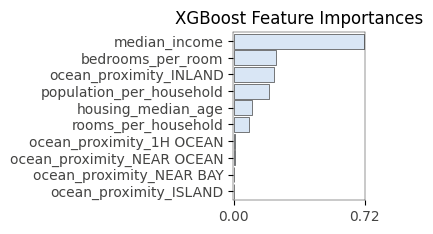

In [18]:
# Random Forest - Use the model's built-in feature importance
rf_importances = pd.Series(rf_best.feature_importances_, index=X_train_cleaned.columns)

# XGBoost - Use the model's built-in feature importance
xgb_importances = pd.Series(xgb_best.feature_importances_, index=X_train_cleaned.columns)

# Visualize feature importance - Show only for Random Forest and XGBoost
# Random Forest
rf_imp = importances(rf_best, X_test_cleaned, y_test)  # Using permutation
viz_rf = plot_importances(rf_imp)
plt.title('Random Forest Feature Importances')
plt.show()

# XGBoost
xgb_imp = importances(xgb_best, X_test_cleaned, y_test)  # Using permutation
viz_xgb = plot_importances(xgb_imp)
plt.title('XGBoost Feature Importances')
plt.show()


## Results and Discussion
(1)**Model Performance Comparison**

Among all the models tested, the Random Forest performed best in terms of the coefficient of determination (R²) and Root Mean Squared Error (RMSE). The Random Forest model enhances precision and stability by building multiple decision trees and averaging or taking a majority vote of their predictions. Additionally, the introduction of randomness in sample and feature selection can effectively reduce overfitting and enhance generalization capabilities across complex datasets.

(2)**Factors Influencing California Housing Prices**

Whether through correlation calculations between housing prices and various feature elements, or through comprehensive analysis using the Random Forest and XGBoost models, the median income was found to be the most important predictor of housing prices in California. This reveals the significant impact of median income on housing prices: higher income levels correspond to stronger purchasing power, which, in turn, correlates with higher property prices. This finding underscores the critical role of economic factors in housing market dynamics.



## Conclusion
By analysing the California house price dataset, this study establishes that median income is the most significant factor influencing house prices and that the **Random Forest** model demonstrates the best performance in predicting house prices. These findings provide a scientific basis for understanding house price volatility and predicting house price trends.

The results of this study are instructive for policymakers when considering housing market interventions, especially in improving housing affordability for low-income populations. In addition, property developers can use the available property information and user profiles to predict market trends and optimise investment strategies.

Future research could consider incorporating more macroeconomic variables into the model, such as interest rates, employment rates and education levels, to more comprehensively analyse and predict house price movements. In addition, exploring the differences in house prices between different regions is also a valuable direction for future research.



## Reference
Gupta, R., 2013. Forecasting house prices for the four census regions and the aggregate US economy in a data-rich environment. Applied Economics, 45(33), pp.4677-4697.

Serrano, W., 2022. The random neural network in price predictions. Neural computing and applications, 34(2), pp.855-873.

Vineeth, N., Ayyappa, M. and Bharathi, B., 2018. House price prediction using machine learning algorithms. In Soft Computing Systems: Second International Conference, ICSCS 2018, Kollam, India, April 19–20, 2018, Revised Selected Papers 2 (pp. 425-433). Springer Singapore.

Featherman, M.S. and Pavlou, P.A., 2003. Predicting e-services adoption: a perceived risk facets perspective. International journal of human-computer studies, 59(4), pp.451-474.


**The code is available here:**

**https://github.com/OnTheMon/CASA0006-Data-Science-for-Spatial-Systems**